In [1]:
%load_ext autoreload
%autoreload 2

import os
import wget
import zipfile
import numpy as np
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
from utils import *
from collections import Counter
from tqdm import tqdm
import time
import geopandas as gpd
import multiprocessing



# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Introduction

## Graph Theory

---

## Aim of the project

<!-- Given a social network, which of its nodes are more central? This question has been asked many times in sociology, psychology and computer science, and a whole plethora of centrality measures (a.k.a. centrality indices, or rankings) were proposed to account for the importance of the nodes of a network. 

These networks, typically generated directly or indirectly by human activity and interaction (and therefore hereafter dubbed social”), appear in a large variety of contexts and often exhibit a surprisingly similar structure. One of the most important notions that researchers have been trying to capture in such networks is “node centrality”: ideally, every node (often representing an individual) has some degree of influence or importance within the social domain under  consideration, and one expects such importance to surface in the structure of the social network; centrality is a quantitative measure that aims at revealing the importance of a node.

Among the types of centrality that have been considered in the literature, many have to do with distances between nodes. Take, for instance, a node in an undirected connected network: if the sum of distances to all other nodes is large, the node under consideration is peripheral; this is the starting point to define Bavelas's closeness centrality \cite{closeness}, which is the reciprocal of peripherality (i.e., the reciprocal of the sum of distances to all other nodes). 

The role played by shortest paths is justified by one of the most well-known features of complex networks, the so-called small-world phenomenon. A small-world network is a graph where the average distance between nodes is logarithmic in the size of the network, whereas the clustering coefficient is larger (that is, neighborhoods tend to be denser) than in a random Erdős-Rényi graph with the same size and average distance. The fact that social networks (whether electronically mediated or not) exhibit the small-world property is known at least since Milgram's famous experiment and is arguably the most popular of all features of complex networks. For instance, the average distance of the Facebook graph was recently established to be just $4.74$. -->

# The Erdős-Rényi model

<!-- Before 1960, graph theory mainly dealt with the properties of specific individual graphs. In the 1960s, Paul Erdős and Alfred Rényi initiated a systematic study of random graphs. Random graph theory is, in fact, not the study of individual graphs, but the study of a statistical ensemble of graphs (or, as mathematicians prefer to call it, a probability space of graphs). The ensemble is a class consisting of many different graphs, where each graph has a probability attached to it. A property studied is said to exist with probability $P$ if the total probability of a graph in the ensemble possessing that property is $P$ (or the total fraction of graphs in the ensemble that has this property is $P$). This approach allows the use of probability theory in conjunction with discrete mathematics for studying graph ensembles.  A property is said to exist for a class of graphs if the fraction of graphs in the ensemble which does not have this property is of zero measure. This is usually termed as a property of \emph{almost every (a.e.)} graph. Sometimes the terms “almost surely” or “with high probability” are also used (with the former usually taken to mean that the residual probability vanishes exponentially with the system size).  -->

Prior to the 1960s, graph theory primarily focused on the characteristics of individual graphs. In the 1960s, Paul Erdős and Alfred Rényi introduced a systematic approach to studying random graphs, which involves analyzing a collection, or ensemble, of many different graphs. Each graph in the ensemble is assigned a probability, and a property is said to hold with probability $P$ if the total probability of the graphs in the ensemble possessing that property is $P$, or if the fraction of graphs in the ensemble with the property is $P$. This method allows for the application of probability theory in conjunction with discrete math to study ensembles of graphs. A property is considered to hold for a class of graphs if the fraction of graphs in the ensemble without the property has zero measure, which is typically referred to as being true for "almost every" graph in the ensemble. The terms "almost surely" and "with high probability" may also be used, with the former generally indicating that the residual probability decreases exponentially with the size of the system


## Erdős-Rényi graphs

<!-- Two well-studied graph ensembles are $G_{N,M}$, the ensemble of all graphs with $N$ nodes and $M$ edges, and $G_{N,p}$, the ensemble of all graphs with $N$ nodes and probability $p$ of any two nodes being connected. These two families, initially studied by Erdős and Rényi, are known to be similar if $M = \binom{N}{2} p$, so as long $p$ is not too close to $0$ or $1$ they are referred to as ER graphs. 

An important attribute of a graph is the average degree, i.e., the average number of edges connected to each node. We will denote the degree of the ith node by $k_i$ and the average degree by $ \langle r \rangle $ . $N$-vertex graphs with $\langle k \rangle = O(N^0)$ are called sparse graphs. 

An interesting characteristic of the ensemble $G_{N,p}$ is that many of its properties have a related threshold function, $p_t(N)$, such that the property exists, in the “thermodynamic limit” of $N \to \infty$  with probability 0 if $p < p_t$ , and with probability $1$ if $p > p_t$ . This phenomenon is the same as the physical concept of a percolation phase transition. 

Another property is the average path length between any two nodes, which in almost every graph of the ensemble (with $\langle k \rangle > 1$ and finite) is of order $\ln N$ . The small, logarithmic distance is actually the origin of the “small-world” phenomena that characterize networks. -->

There are two well-known ensembles of graphs that have been extensively studied: the ensemble of all graphs with $N$ nodes and $M$ edges, denoted $G_{N,M}$, and the ensemble of all graphs with $N$ nodes and a probability $p$ of any two nodes being connected, denoted $G_{N,p}$. These ensembles, initially studied by Erdős and Rényi, are similar when $M = \binom{N}{2} p$, and are therefore referred to as ER graphs when $p$ is not too close to 0 or 1.

An important feature of a graph is its average degree, or the average number of edges connected to each node. We will denote the degree of the $i$th node by $k_i$ and the average degree by $\langle r \rangle$. Graphs with $N$ nodes and $\langle k \rangle = O(N^0)$ are called sparse graphs.

One interesting property of the ensemble $G_{N,p}$ is that many of its characteristics have a corresponding threshold function, $p_t(N)$, such that the property exists with probability 0 if $p < p_t$ and with probability 1 if $p > p_t$ in the "thermodynamic limit" of $N \to \infty$. This is similar to the physical concept of a percolation phase transition.

Another property of interest is the average path length between any two nodes, which is typically of order $\ln N$ in almost every graph of the ensemble (with $\langle k \rangle > 1$ and finite). This small, logarithmic distance is the source of the "small-world" phenomena that are characteristic of networks.


## Scale-free networks

<!-- The Erdős-Rényi model has traditionally been the dominant subject of study in the field of random graphs. Recently, however, several studies of real-world networks have found that the ER model fails to reproduce many of their observed properties. One of the simplest properties of a network that can be measured directly is the degree distribution, or the fraction P(k) of nodes having k connections (degree $k$). A well-known result for ER networks is that the degree distribution is Poissonian,

\begin{equation}
    P(k) = \frac{e^{z} z^k}{k!}
\end{equation}

Where $z = \langle k \rangle$. is the average degree.  Direct measurements of the degree distribution for real networks show that the Poisson law does not apply. Rather, often these nets exhibit a scale-free degree distribution:

\begin{equation}
    P(k) = ck^{-\gamma} \quad \text{for} \quad k = m, ... , K
\end{equation}

Where $c \sim (\gamma -1)m^{\gamma - 1}$ is a normalization factor, and $m$ and $K$ are the lower and upper cutoffs for the degree of a node, respectively. The divergence of moments higher then $\lceil \gamma -1 \rceil$ (as  $K \to \infty$ when $N \to \infty$) is responsible for many of the anomalous properties attributed to scale-free networks. 

All real-world networks are finite and therefore all their moments are finite. The actual value of the cutoff K plays an important role. It may be approximated by noting that the total probability of nodes with $k > K$ is of order $1/N$

\begin{equation}
    \int_K^\infty P(k) dk \sim \frac{1}{N}
\end{equation}

This yields the result

\begin{equation}
    K \sim m N^{1/(\gamma -1)}
\end{equation}

The degree distribution alone is not enough to characterize the network. There are many other quantities, such as the degree-degree correlation (between connected nodes), the spatial correlations, the clustering coefficient, the betweenness or central-ity distribution, and the self-similarity exponents. -->

The Erdős-Rényi model has long been the primary focus of research in the field of random graphs. However, recent studies of real-world networks have shown that the ER model does not accurately capture many of their observed properties. One such property that can be easily measured is the degree distribution, or the fraction $P(k)$ of nodes with $k$ connections (degree $k$). A well-known result for ER networks is that the degree distribution follows a Poisson distribution, given by

\begin{equation}
P(k) = \frac{e^{z} z^k}{k!}
\end{equation}

where $z = \langle k \rangle$ is the average degree. However, measurements of the degree distribution for real networks often show that the Poisson law does not hold, instead exhibiting a scale-free degree distribution of the form

\begin{equation}
P(k) = ck^{-\gamma} \quad \text{for} \quad k = m, ... , K
\end{equation}

where $c \sim (\gamma -1)m^{\gamma - 1}$ is a normalization factor, and $m$ and $K$ are the lower and upper cutoffs for the degree of a node, respectively. The divergence of moments higher than $\lceil \gamma -1 \rceil$ (as $K \to \infty$ when $N \to \infty$) is responsible for many of the unusual properties attributed to scale-free networks.

It is important to note that all real-world networks are finite, so all of their moments are finite as well. The actual value of the cutoff $K$ plays a significant role, and can be approximated by noting that the total probability of nodes with $k > K$ is approximately $1/N$, or

\begin{equation}
\int_K^\infty P(k) dk \sim \frac{1}{N}
\end{equation}

This gives the result

\begin{equation}
K \sim m N^{1/(\gamma -1)}
\end{equation}

The degree distribution is not the only characteristic that can be used to describe a network. Other quantities, such as the degree-degree correlation (between connected nodes), spatial correlations, clustering coefficient, betweenness or centrality distribution, and self-similarity exponents, can also provide insight into the network's structure and behavior.

# Diameter and fractal dimension

<!-- Regular lattices can be viewed as networks embedded in Euclidean space, of a well-defined dimension, $d$. This means that $n(r)$, the number of nodes within a distance $r$ from an origin, grows as $n(r) \sim r^d$ (for large $r$). For fractal objects, $d$ in the last relation may be a non-integer and is replaced by the fractal dimension $d_f$ 

An example of a network where the above power laws are not valid is the Cayley tree (also known as the Bethe lattice). The Cayley tree is a regular graph, of fixed degree $z$, and no loops. An infinite Cayley tree cannot be embedded in a Euclidean space of finite dimensionality. The number of nodes at $l$ is $n(l) \sim (z - 1)^l$ . Since the exponential growth is faster than any power law, Cayley trees are referred to as infinite-dimensional systems. 

In most random network models, the structure is locally tree-like (since most loops occur only for $n(l) \sim N$), and since the number of nodes grows as $n(l) \sim \langle k - 1 \rangle^l$, they are also infinite dimensional. As a consequence, the diameter of such graphs (i.e., the minimal path between the most distant nodes) scales as $D \sim \ln N$. Many properties of ER networks, including the logarithmic diameter, are also present in Cayley trees. This small diameter in ER graphs and Cayley trees is in contrast to that of finite-dimensional lattices, where $D \sim N^{1/d_l}$. 

Similar to ER, percolation on infinite-dimensional lattices and the Cayley tree  yields a critical threshold $p_c = 1/(z - 1)$. For $p > p_c$, a “giant cluster” of order $N$ exists, whereas for $p < pc$,only small clusters appear. For infinite-dimensional lattices (similar to ER networks) at criticality, $p = p_c$ , the giant component is of size $N^{2/3}$. This last result follows from the fact that percolation on lattices in dimension $d \geq d_c = 6$ is in the same universality class as infinite-dimensional percolation, where the fractal dimension of the giant cluster is $d_f = 4$, and therefore the size of the giant cluster scales as $N^{d_f/d_c} = N^{2/3}$. The dimension $d_c$ is called the “upper critical dimension.” Such an upper critical dimension exists not only in percolation phenomena, but also in other physical models, such as in the self-avoiding walk model for polymers and in the Ising model for magnetism; in both these cases $d_c = 4$.

Watts and Strogatz suggested a model that retains the local high clustering of lattices (i.e., the neighbors of a node have a much higher probability of being neighbors than in random graphs) while reducing the diameter to $D \sim \ln N$ . This so-called, “small-world network” is achieved by replacing a fraction $\varphi$ of the links in a regular lattice with random links, to random distant neighbors.  -->

Regular lattices can be viewed as networks embedded in Euclidean space of a defined dimension $d$, meaning that $n(r)$, the number of nodes within a distance $r$ from an origin, grows as $n(r) \sim r^d$ for large $r$. For fractal objects, the dimension $d$ in this relation may be a non-integer and is replaced by the fractal dimension $d_f$.

One example of a network where these power laws do not hold is the Cayley tree, also known as the Bethe lattice, which is a regular graph of fixed degree $z$ with no loops. An infinite Cayley tree cannot be embedded in a Euclidean space of finite dimensionality. The number of nodes at level $l$ grows as $n(l) \sim (z - 1)^l$, which is faster than any power law, making Cayley trees infinite-dimensional systems.

Many random network models have locally tree-like structure (since most loops occur only when $n(l) \sim N$), and since the number of nodes grows as $n(l) \sim \langle k - 1 \rangle^l$, they are also infinite dimensional. As a result, the diameter of such graphs (i.e., the shortest path between the most distant nodes) scales as $D \sim \ln N$. Many properties of ER networks, including the logarithmic diameter, are also present in Cayley trees. This small diameter is in contrast to that of finite-dimensional lattices, where $D \sim N^{1/d_l}$.

Like ER networks, percolation on infinite-dimensional lattices and the Cayley tree exhibits a critical threshold $p_c = 1/(z - 1)$. For $p > p_c$, a "giant cluster" of size $N$ exists, while for $p < p_c$, only small clusters are present. At criticality ($p = p_c$) in infinite-dimensional lattices (similar to ER networks), the giant component is of size $N^{2/3}$. This result follows from the fact that percolation on lattices in dimension $d \geq d_c = 6$ is in the same universality class as infinite-dimensional percolation, where the fractal dimension of the giant cluster is $d_f = 4$, resulting in a size of the giant cluster that scales as $N^{d_f/d_c} = N^{2/3}$. The dimension $d_c$ is known as the "upper critical dimension," and this concept exists not only in percolation phenomena, but also in other physical models such as the self-avoiding walk model for polymers and the Ising model for magnetism, in both of which $d_c = 4$.

Watts and Strogatz proposed a model that retains the high local clustering of lattices (i.e., the neighbors of a node have a higher probability of being neighbors than in random graphs) while reducing the diameter to $D \sim \ln N$. This so-called "small-world network" is achieved by replacing a fraction $\varphi$ of the links in a regular lattice with random links to random, distant neighbors.



## Random graphs as a model of real networks

<!-- Many natural and man-made systems are networks, i.e., they consist of objects and interactions between them. These include computer networks, in particular the Internet, logical networks, such as links between WWW pages, and email networks, where a link represents the presence of a person's address in another person's address book. Social interactions in populations, work relations, etc. can also be modeled by a network structure. Networks can also describe possible actions or movements of a system in a configuration space (a phase space), and the nearest configurations are connected by a link. All the above examples and many others have a graph structure that can be studied. Many of them have some ordered structure, derived from geographical or geometrical considerations, cluster and group formation, or other specific properties.  However, most of the above networks are far from regular lattices and are much more complex and random in structure. Therefore, it can be assumed (with a lot of precaution) that they maintain many properties of the appropriate random graph model. 

In many aspects scale-free networks can be regarded as a generalization of ER networks. For large $\gamma$ (usually, for $\gamma > 4$) the properties of scale-free networks, such as distances, optimal paths, and percolation, are the same as in ER networks. In contrast, for $\gamma < 4$, these properties are very different and can be regarded as anomalous. The anomalous behavior of scale-free networks is due to the strong heterogeneity in the degree of the nodes, which breaks the node-to-node translational homogeneity (symmetry) that exists in the classical
homogeneous networks, such as lattices, Cayley trees, and ER graphs. The small variation of the degrees in the ER model or in scale-free networks with large $gamma$ is insufficient to break this symmetry, and therefore many results for ER networks are the same as for Cayley trees, where the degree of each node is the same. -->

Many natural and man-made systems can be represented as networks, consisting of objects and interactions between them. Examples include computer networks, particularly the Internet, logical networks such as links between web pages and email networks, where a link represents the presence of an individual's address in another person's address book, and social interactions in populations or work relations. Networks can also describe possible actions or movements of a system in a configuration space (a phase space), with nearest configurations connected by a link. All of these examples and many others have a graph structure that can be studied. Many of these networks have some ordered structure, derived from geographical or geometrical considerations, cluster and group formation, or other specific properties, but most of them are far from regular lattices and are much more complex and random in structure. Therefore, it is often assumed (with caution) that they share many properties with the appropriate random graph model.

In many ways, scale-free networks can be considered a generalization of ER networks. For large $\gamma$ (typically $\gamma > 4$), the properties of scale-free networks such as distances, optimal paths, and percolation are the same as in ER networks. In contrast, for $\gamma < 4$, these properties are very different and can be considered anomalous. The anomalous behavior of scale-free networks is due to the strong heterogeneity in the degrees of the nodes, which breaks the node-to-node translational homogeneity (symmetry) present in

---

# Discovering the datasets

To perform our analysis, we will use the following datasets:

- **Brightkite**
- **Gowalla**
- **Foursquare**

We can download the datasets using the function `download_dataset` from the `utils` module. It will download the datasets in the `data` folder, organized in sub-folders in the following way:

```
data
├── brightkite
│   ├── brightkite_checkins.txt
│   └── brightkite_friends_edges.txt
├── foursquare
│   ├── foursquare_checkins.txt
│   ├── foursquare_friends_edges.txt
│   └── raw_POIs.txt
└── gowalla
    ├── gowalla_checkins.txt
    └── gowalla_friends_edges.txt
```

If any of the datasets is already downloaded, it will not be downloaded again. For further details about the function below, please refer to the `utils` module.

> NOTE: the Stanford servers tends to be slow, so it may take a while to download the datasets. It's gonna take about 5 minutes to download all the datasets.

---

### A deeper look at the datasets



In [ ]:
download_datasets()

Let's have a deeper look at them.

## Brightkite

[Brightkite](http://www.brightkite.com/) was a location-based social networking service that allowed users to share their locations by checking in. The friendship network data was collected using the Brightkite public API. There are two datasets available for analysis: 

- `brightkite_checkins.txt`, which contains check-in data in the form of a tab-separated file with five columns: `user id`, `check-in time`, `latitude`, `longitude`, and `location id`
  
- `brightkite_friends_edges.txt`, which is a tab-separated file with two columns containing user IDs and representing the friendship network in the form of a graph edge list. 

The `brightkite_checkins.txt` dataset must be converted into a graph before it can be analyzed properly, while the `brightkite_friends_edges.txt` dataset is already in a usable form for graph analysis.

Let's have a more clear view of where our data have been generated

Number of unique users:  35538


<AxesSubplot: >

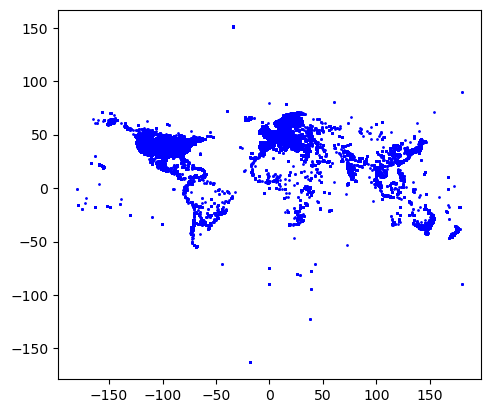

In [4]:
df_brighkite = pd.read_csv(os.path.join('test_data', 'brightkite', 'brightkite_checkins_full.txt'), 
                            sep='\t', 
                            header=None,
                            names=['user id', 'check-in time', 'latitude', 'longitude', 'location id'],
                            parse_dates=['check-in time'],
                            engine='pyarrow')

# take only the dates from 2009
df_brighkite = df_brighkite[df_brighkite['check-in time'].dt.year == 2009]

# convert the dataframe to geopandas dataframe
gdf_brightkite = gpd.GeoDataFrame(df_brighkite, geometry=gpd.points_from_xy(df_brighkite.longitude, df_brighkite.latitude))

# plot the geopandas dataframe
print("Number of unique users: ", len(df_brighkite['user id'].unique()))
gdf_brightkite.plot(marker='o', color='blue', markersize=1)

Familiar shape, isn't it? As we can see there are ~35k, a bit too much for our future computation. Let's take a subset, like Europe!

Number of unique users in Europe:  8525


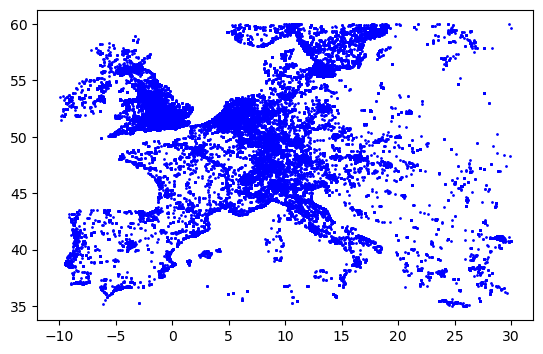

In [7]:
gdf_brightkite = gdf_brightkite[gdf_brightkite['latitude'] < 60]
gdf_brightkite = gdf_brightkite[gdf_brightkite['latitude'] > 35]
gdf_brightkite = gdf_brightkite[gdf_brightkite['longitude'] < 30]
gdf_brightkite = gdf_brightkite[gdf_brightkite['longitude'] > -10]

gdf_brightkite.plot(marker='o', color='blue', markersize=1)

# update the pandas dataframe with the new values
df_brighkite = gdf_brightkite
print("Number of unique users in Europe: ", len(df_brighkite['user id'].unique()))

# remove from memory the geopandas dataframe, it was only used for plotting
del gdf_brightkite

Perfect! Now we can create a new .txt file, only with the information that we need

In [17]:
# update the file with the new values. Drop the columns that are not needed
df_brighkite.to_csv(
    os.path.join('test_data', 'brightkite', 'brightkite_checkins.txt'), 
    sep='\t', 
    header=False, 
    index=False, 
    columns=['user id', 'location id'])

## Gowalla

Gowalla is a location-based social networking website where users share their locations by checking-in. The friendship network is undirected and was collected using their public API. As for Brightkite, we will work with two different datasets. This is how they look like after being filtered by the `download_dataset` function:

- `data/gowalla/gowalla_checkins.txt`: the checkins,  a tsv file with 5 columns: `user id`, `check-in time`, `latitude`, `longitude`, `location id`

- `data/gowalla/gowalla_friends_edges.txt`: the friendship network, a tsv file with 2 columns of users ids. This file it's untouched by the function, it's in the form of a graph edge list. 

--- 

Let's have a more clear view of where our data have been generated

Number of unique users:  12611


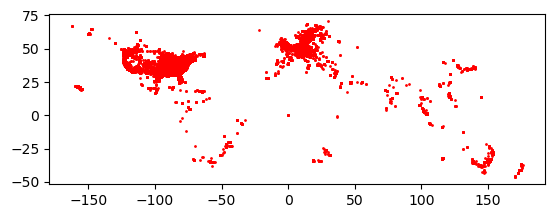

In [23]:
df_gowalla = pd.read_csv(os.path.join('test_data', 'gowalla', 'gowalla_checkins_full.txt'),
                            sep='\t', 
                            header=None,
                            names=['user id', 'check-in time', 'latitude', 'longitude', 'location id'],
                            parse_dates=['check-in time'],
                            engine='pyarrow')

# take only the dates from 2009
df_gowalla = df_gowalla[df_gowalla['check-in time'].dt.year == 2009]

# convert the dataframe to geopandas dataframe
gdf_gowalla = gpd.GeoDataFrame(df_gowalla, geometry=gpd.points_from_xy(df_gowalla.longitude, df_gowalla.latitude))

# plot the geopandas dataframe
gdf_gowalla.plot(marker='o', color='red', markersize=1)
print("Number of unique users: ", len(df_gowalla['user id'].unique()))

This is still a bit too much, to help us in the next sections, let's take a subset of the European are

Number of unique users in the UE area:  3718


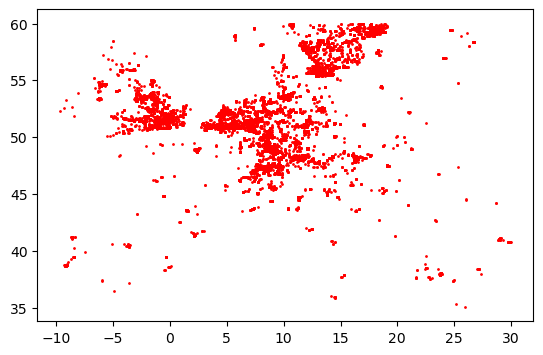

In [24]:
gdf_gowalla = gdf_gowalla[gdf_gowalla['latitude'] < 60]
gdf_gowalla = gdf_gowalla[gdf_gowalla['latitude'] > 35]
gdf_gowalla = gdf_gowalla[gdf_gowalla['longitude'] < 30]
gdf_gowalla = gdf_gowalla[gdf_gowalla['longitude'] > -10]

gdf_gowalla.plot(marker='o', color='red', markersize=1)

df_gowalla = gdf_gowalla
print("Number of unique users in the UE area: ", len(df_gowalla['user id'].unique()))

# remove from memory the geopandas dataframe, it was only used for plotting
del gdf_gowalla

Perfect! Now we can create a new .txt file, only with the information that we need

In [25]:
# update the file with the new values. Drop the columns that are not needed
df_gowalla.to_csv(
    os.path.join('test_data', 'gowalla', 'gowalla_checkins.txt'), 
    sep='\t', 
    header=False, 
    index=False, 
    columns=['user id', 'location id'])

## Foursquare

[Foursquare](https://foursquare.com/) is a location-based social networking website where users share their locations by checking-in. This dataset includes long-term (about 22 months from Apr. 2012 to Jan. 2014) global-scale check-in data collected from Foursquare, and also two snapshots of user social networks before and after the check-in data collection period (see more details in our paper). We will work with three different datasets:

- `foursquare_checkins.txt`: a tsv file with 4 columns: `User ID`, `Venue ID`, `UTC time`, `Timezone offset in minutes`  

- `foursquare_friends_edges.txt`: the friendship network, a tsv file with 2 columns of users ids. This is in the form of a graph edge list. 

- `raw_POIs.txt`: the POIS, a tsv file with 5 columns: `Venue ID`, `Latitude`, `Longitude`, `Venue category name`, `Country code (ISO)`.

--- 

This dataset is by far the biggest of the 3 that we got. The check-in dataset contains 22,809,624 checkins by 114,324 users on 3,820,891 venues. The social network data contains 607,333 friendships. As explained before, we are going to need sub-samples! In this case, we'll take only data from 2012 that have been generated in Italy. Due to the size of the full network, this time we won't plot it, otherwise our RAM might cry. 

Starting to plot
Number of unique users in Italy:  2555


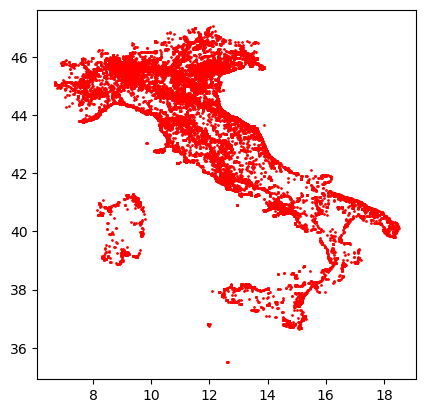

In [14]:
import pandas as pd
import geopandas as gpd

df_foursquare_POIS = pd.read_csv(os.path.join('test_data', 'foursquare', 'raw_POIs.txt'), 
                                    sep='\t',
                                    header=None,
                                    names=['venue id', 'latitude', 'longitude', 'venue category name', 'ISO code'],
                                    dtype={'venue id': str, 'latitude': float, 'longitude': float, 'venue category name': str, 'ISO code': str},
                                    engine='c')

df_foursquare_checkins = pd.read_csv(os.path.join('test_data', 'foursquare', 'foursquare_checkins_full.txt'),
                                        sep='\t',
                                        header=None,
                                        names=['user id', 'venue id', 'UTC time', 'offset'],
                                        dtype={'user id': str, 'venue id': str, 'UTC time': str, 'offset': int},
                                        engine='c')

# Take only the data with IT ISO code
df_foursquare_POIS = df_foursquare_POIS[df_foursquare_POIS['ISO code'] == 'IT']

# Take only the checkins that are in the POIs (filtered by ISO code) and viceversa
df_foursquare_checkins = df_foursquare_checkins[df_foursquare_checkins['venue id'].isin(df_foursquare_POIS['venue id'])]
df_foursquare_POIS = df_foursquare_POIS[df_foursquare_POIS['venue id'].isin(df_foursquare_checkins['venue id'])]

# Convert to datetime
df_foursquare_checkins['UTC time'] = pd.to_datetime(df_foursquare_checkins['UTC time'])

# Take only the data from 2012
df_foursquare_checkins = df_foursquare_checkins[df_foursquare_checkins['UTC time'].dt.year == 2012]

# convert the dataframe to geopandas dataframe
gdf_foursquare_POIS = gpd.GeoDataFrame(df_foursquare_POIS, geometry=gpd.points_from_xy(df_foursquare_POIS.longitude, df_foursquare_POIS.latitude))

# plot the geopandas dataframe
print("Starting to plot")
gdf_foursquare_POIS.plot(marker='o', color='red', markersize=1)
print('Number of unique users in Italy: ', len(df_foursquare_checkins['user id'].unique()))

# delete from memory the geo dataframe, it was only used for plotting
del gdf_foursquare_POIS

In [15]:
df_foursquare_checkins.to_csv(
    os.path.join('test_data', 'foursquare', 'foursquare_checkins.txt'),
    sep='\t',
    header=False,
    index=False,
    columns=['user id', 'venue id'])

# Building the networks

We are going to build the the networks for the three datasets as an undirected graph $M = (V, E)$, where $V$ is the set of nodes and $E$ is the set of edges. The nodes represent the users and the edges indicates that two individuals visited the same location at least once.

The check-ins files of the three datasets are not in the form of a graph edge list, so we need to manipulate them. Let's have a look at the number of lines of each file.

In [26]:
def count_lines_and_unique_elements(file):
    df = pd.read_csv(file, sep='\t', header=None)
    print('Number of lines: ', len(df))
    print('Number of unique elements: ', len(df[0].unique()))

gowalla_path = os.path.join('test_data', 'gowalla', 'gowalla_checkins.txt')
brightkite_path = os.path.join('test_data', 'brightkite', 'brightkite_checkins.txt')
foursquare_path = os.path.join('test_data', 'foursquare', 'foursquare_checkins.txt')

_ = [gowalla_path, brightkite_path, foursquare_path]

for path in _:
    print(path.split(os.sep)[-2])
    count_lines_and_unique_elements(path)
    print()

gowalla
Number of lines:  83269
Number of unique elements:  3718

brightkite
Number of lines:  391220
Number of unique elements:  8525

foursquare
Number of lines:  125076
Number of unique elements:  2555



We would like to build a graph starting from an edge list. To do that, we are going to check, for each venue, all the users that visited it. Then, we will create an edge between each pair of users that visited the same venue (avoiding repetitions). This can be easily done in python, but it's going to be a bit slow (this is why we are considering sub-samples of the datasets). Let's see how to do it.

```python
# let df be the dataframe ["user_id", "venue_id"] of the checkins

venues_users = df.groupby("venue_id")["user_id"].apply(set)

        for users in venues_users:
            for user1, user2 in combinations(users, 2):
                G.add_edge(user1, user2)
```

It the `utilis.py` module, we have a function that does exactly this called `create_graph_from_checkins`. It takes as input the name of the dataset and returns a networkx graph object. By default it will also write the edge list to a file in the respective dataset folder. The options are

- `brightkite`
- `gowalla`
- `foursquare`

Let's see how it works:

In [2]:
# It takes about 3 minutes to create the all the 4 graphs on a i7-8750H CPU

G_brighkite_checkins = create_graph_from_checkins('brightkite')
G_brighkite_checkins.name = 'Brightkite Checkins Graph'

G_gowalla_checkins = create_graph_from_checkins('gowalla')
G_gowalla_checkins.name = 'Gowalla Checkins Graph'

G_foursquare_checkins = create_graph_from_checkins('foursquare')
G_foursquare_checkins.name = 'Foursquare Checkins Graph'


Creating the graph for the dataset brightkite...


100%|██████████| 84831/84831 [00:00<00:00, 285874.40it/s]


Done! The graph has 292973 edges  and 6493 nodes

Creating the graph for the dataset gowalla...


100%|██████████| 31095/31095 [00:00<00:00, 329181.10it/s]


Done! The graph has 62790 edges  and 3073 nodes

Creating the graph for the dataset foursquare...


100%|██████████| 40650/40650 [00:00<00:00, 131337.54it/s]


Done! The graph has 246702 edges  and 2324 nodes


### Friendship network

Now we want to create a graph where two users are connected if they are friends in the social network. We are intending the concept of friendship in a "facebook way", not a "twitter way". Less empirically, the graphs is not going to be directed and the edges are not going to be weighted. A user can't be friend with himself, and can't be friend with a user without the user being friend with him.

Since we filtered the checkins for foursquare and gowalla, we are considering only the users that are also present in the check-ins graph. We can build this graph with the function `create_friendships_graph` in the `utils.py` module. It takes as input the name of the dataset and returns a networkx graph object. By default it will also write the edge list to a file in the respective dataset folder. The options are

- `brightkite`
- `gowalla`
- `foursquare`

> **NOTE:** This functions is implemented without the necessity of the checkins graphs being loaded in memory, it uses the edge list file. This choice was made since someone may want to perform some analysis only on the friendship network and so there is no need to load the checkins graph and waste memory. Furthermore, networkx is tremendously slow when loading a graph from an edge list file (since it's written in pure python), so this choice is also motivated by the speed of the function.

Let's see how it works:

In [3]:
G_brighkite_friends = create_friendships_graph('brightkite')
print("Computation done for Brightkite friendship graph")
G_brighkite_friends.name = 'Brightkite Friendship Graph'


G_gowalla_friends = create_friendships_graph('gowalla')
print("Computation done for Gowalla friendship graph")
G_gowalla_friends.name = 'Gowalla Friendship Graph'


G_foursquare_friends = create_friendships_graph('foursquare')
print("Computation done for Foursquare friendship graph")
G_foursquare_friends.name = 'Foursquare Friendship Graph'

Computation done for Brightkite friendship graph
Computation done for Gowalla friendship graph
Computation done for Foursquare friendship graph


Now that we have our graphs, let's have a look at some basic information about them

In [37]:
for G in [G_brighkite_friends, G_gowalla_friends, G_foursquare_friends]:
    print(G.name)
    print('Number of nodes: ', G.number_of_nodes())
    print('Number of edges: ', G.number_of_edges())
    print()

Brightkite Friendship Graph
Number of nodes:  5420
Number of edges:  14690

(Filtered) Gowalla Friendship Graph
Number of nodes:  2294
Number of edges:  5548

Foursquare Friendship Graph
Number of nodes:  1397
Number of edges:  5323



# Proprieties of the structure of the networks
<!-- 
Given a social network, which of its nodes are more central? This question has been asked many times in sociology, psychology and computer science, and a whole plethora of centrality measures (a.k.a. centrality indices, or rankings) were proposed to account for the importance of the nodes of a network. 

These networks, typically generated directly or indirectly by human activity and interaction (and therefore hereafter dubbed "social"), appear in a large variety of contexts and often exhibit a surprisingly similar structure. One of the most important notions that researchers have been trying to capture in such networks is “node centrality”: ideally, every node (often representing an individual) has some degree of influence or importance within the social domain under  consideration, and one expects such importance to surface in the structure of the social network; centrality is a quantitative measure that aims at revealing the importance of a node. 

Among the types of centrality that have been considered in the literature, many have to do with distances between nodes. Take, for instance, a node in an undirected connected network: if the sum of distances to all other nodes is large, the node under consideration is peripheral; this is the starting point to define Bavelas's closeness centrality, which is the reciprocal of peripherality (i.e., the reciprocal of the sum of distances to all other nodes). 

The role played by shortest paths is justified by one of the most well-known features of complex networks, the so-called **small-world phenomenon**. A small-world network is a graph where the average distance between nodes is logarithmic in the size of the network, whereas the clustering coefficient is larger (that is, neighborhoods tend to be denser) than in a random Erdős-Rényi graph with the same size and average distance. The fact that social networks (whether electronically mediated or not) exhibit the small-world property is known at least since Milgram's famous experiment and is arguably the most popular of all features of complex networks. For instance, the average distance of the Facebook graph was recently established to be just $4.74$ 

--- 

In 1998 Watts and Strogatz proposed a simple model for generating networks with the small-world property. The model is based on a regular lattice of $N$ nodes, where each node is connected to its $k$ nearest neighbors. The model then proceeds as follows: for each edge, the probability $p$ of rewiring it is considered. If the edge is rewired, it is replaced by a random edge with uniform probability. The resulting network is a small-world network with $N$ nodes, $k$ nearest neighbors, and average distance $\log(N)/\log(k)$. -->

### Introduzione da scrivere

To help us visualize the results of our analysis we can create a dataframe and fill it with all the information that we will retrive from our networks in this section.

As we'll see in the cells below, the full networks are very big, even after the filtering that we did. This leads to long run times for the functions that we are going to use. To avoid this, we are going to use a sub-sample of the networks. Depending on how much we want to sample, our results will be more or less accurate. 

What I suggest to do while reviewing this network is to use higher values for the sampling rate, so that you can see the results faster. This will give you a general idea of how the implemented functions work. Then, at the end of this section I have provided a link from my GitHub repository where you can download the results obtained with very low sampling rates. In this way you can test the functions with mock-networks and see if they work as expected, then we can proceed with the analysis using the more accurate results.

In [6]:
checkins_graphs = [G_brighkite_checkins, G_gowalla_checkins, G_foursquare_checkins]
friendships_graph = [G_brighkite_friends, G_gowalla_friends, G_foursquare_friends]

graphs_all = checkins_graphs + friendships_graph

In [38]:
analysis_results = pd.DataFrame(columns=['Graph', 'Number of Nodes', 'Number of Edges', 'Average Degree', 'Average Clustering Coefficient', 'log N', 'Average Shortest Path Length', 'betweenness centrality'], index=None)

for graph in graphs_all:
    analysis_results = analysis_results.append(
        {'Graph': graph.name, 
        'Number of Nodes': graph.number_of_nodes(), 
        'log N': np.log(graph.number_of_nodes()),
        'Number of Edges': graph.number_of_edges()}, 
        ignore_index=True)

analysis_results

,Graph,Number of Nodes,Number of Edges,Average Degree,Average Clustering Coefficient,log N,Average Shortest Path Length,betweenness centrality
0,Brightkite Checkins Graph,6493,292973,NaN,NaN,8.778480,NaN,NaN
1,Gowalla Checkins Graph,3073,62790,NaN,NaN,8.030410,NaN,NaN
2,Foursquare Checkins Graph,2324,246702,NaN,NaN,7.751045,NaN,NaN
3,Brightkite Friendship Graph,5420,14690,NaN,NaN,8.597851,NaN,NaN
4,(Filtered) Gowalla Friendship Graph,2294,5548,NaN,NaN,7.738052,NaN,NaN
5,Foursquare Friendship Graph,1397,5323,NaN,NaN,7.242082,NaN,NaN


## Average Degree

The degree of a node is the number of links connected to it. The average degree alone, is not very useful for our future analysis, so we won't spend much time about it. In the next section we will see that the degree distribution is a much more useful measure.

The degree distribution, $P(k)$, is the fraction of sites having degree $k$. We know from the literature that many real networks do not exhibit a Poisson degree distribution, as predicted in the ER model. In fact, many of them exhibit a distribution with a long, power-law, tail, $P(k) \sim k^{-\gamma}$ with some $γ$, usually between $2$ and 3$.

For know, we will just compute the average degree of our networks and add it to the dataframe.

In [39]:
for G in graphs_all:
    avg_deg = np.mean([d for n, d in G.degree()])
    analysis_results.loc[analysis_results['Graph'] == G.name, 'Average Degree'] = avg_deg

analysis_results

,Graph,Number of Nodes,Number of Edges,Average Degree,Average Clustering Coefficient,log N,Average Shortest Path Length,betweenness centrality
0,Brightkite Checkins Graph,6493,292973,90.242723,NaN,8.778480,NaN,NaN
1,Gowalla Checkins Graph,3073,62790,40.865604,NaN,8.030410,NaN,NaN
2,Foursquare Checkins Graph,2324,246702,212.30809,NaN,7.751045,NaN,NaN
3,Brightkite Friendship Graph,5420,14690,5.420664,NaN,8.597851,NaN,NaN
4,(Filtered) Gowalla Friendship Graph,2294,5548,4.836966,NaN,7.738052,NaN,NaN
5,Foursquare Friendship Graph,1397,5323,7.620616,NaN,7.242082,NaN,NaN


## Clustering coefficient

The clustering coefficient is usually related to a community represented by local structures. The usual definition of clustering is related to the number of triangles in the network. The clustering is high if two nodes sharing a neighbor have a high probability of being connected to each other. There are two common definitions of clustering. The first is global,

\begin{equation}
    C = \frac{3 \times \text{the number of triangles in the network}}{\text{the number of connected triples of vertices}}
\end{equation}

where a “connected triple” means a single vertex with edges running to an unordered
pair of other vertices. 

A second definition of clustering is based on the average of the clustering for single nodes. The clustering for a single node is the fraction of pairs of its linked neighbors out of the total number of pairs of its neighbors:

\begin{equation}
    C_i = \frac{\text{the number of triangles connected to vertex }i}{\text{the number of triples centered on vertex } i}
\end{equation}

For vertices with degree $0$ or $1$, for which both numerator and denominator are zero, we use $C_i = 0$. Then the clustering coefficient for the whole network is the average

\begin{equation}
    C = \frac{1}{n} \sum_{i} C_i
\end{equation}

In both cases the clustering is in the range $0 \leq C \leq 1$. 

In random graph models such as the ER model and the configuration model, the clustering coefficient is low and decreases to $0$ as the system size increases. This is also the situation in many growing network models. However, in many real-world networks the clustering coefficient is rather high and remains constant for large network sizes. This observation led to the introduction of the small-world model, which offers a combination of a regular lattice with high clustering and a random graph. 

---

As one can imagine by the definition given above, this operation is very expensive. The library `networkx` provides a function to compute the clustering coefficient of a graph. In particular, the function `average_clustering` computes the average clustering coefficient of a graph. Unfortunately, since our dataset (even after sub-sampling) are too big to be processed exactly in decent times.

We can use the `average_clustering` function from the `utils` module to compute the average clustering coefficient on a random sub-sample of the graph. The functions takes as input:

- `G: networkx graph object`: the graph on which we want to compute the average clustering coefficient
- `k: int (default=None)`: percentage of nodes to remove from the graph. If k is None, the average clustering coefficient of each connected component is computed using all the nodes of the connected component.

And returns:

- `float`: the average clustering coefficient of the graph

Depending on the machine and the time available, we can choose different values for `k`. Lower values will give us a more precise result, but will take longer to compute. On the other hand, higher values will give us a less precise result, but will be faster to compute. I suggest to use `k=0.9` to test very quickly the function, and at least `k=0.6` to get a more precise result.

> Since the checkins graphs are way bigger then the friendship graphs, I created two for loop to compute the average clustering coefficient with different values of `k`.

In [47]:
for graph in graphs_all:
    print("\nComputing average clustering coefficient for the {}...".format(graph.name))
    start = time.time()
    avg_clustering = nx.average_clustering(graph)
    end = time.time()

    print("\tAverage clustering coefficient: {}".format(avg_clustering))
    print("\tCPU time: " + str(round(end-start,1)) + " seconds")
    analysis_results.loc[analysis_results['Graph'] == graph.name, 'Average Clustering Coefficient'] = avg_clustering

analysis_results


Computing average clustering coefficient for the Brightkite Checkins Graph...
	Average clustering coefficient: 0.7139988006862793
	CPU time: 14.8 seconds

Computing average clustering coefficient for the Gowalla Checkins Graph...
	Average clustering coefficient: 0.5483724940778376
	CPU time: 1.7 seconds

Computing average clustering coefficient for the Foursquare Checkins Graph...
	Average clustering coefficient: 0.6527297407924693
	CPU time: 19.5 seconds

Computing average clustering coefficient for the Brightkite Friendship Graph...
	Average clustering coefficient: 0.21857061612676437
	CPU time: 0.1 seconds

Computing average clustering coefficient for the (Filtered) Gowalla Friendship Graph...
	Average clustering coefficient: 0.23429345031911422
	CPU time: 0.0 seconds

Computing average clustering coefficient for the Foursquare Friendship Graph...
	Average clustering coefficient: 0.18348521948916247
	CPU time: 0.0 seconds


,Graph,Number of Nodes,Number of Edges,Average Degree,Average Clustering Coefficient,log N,Average Shortest Path Length,betweenness centrality
0,Brightkite Checkins Graph,6493,292973,90.242723,0.713999,8.778480,NaN,NaN
1,Gowalla Checkins Graph,3073,62790,40.865604,0.548372,8.030410,NaN,NaN
2,Foursquare Checkins Graph,2324,246702,212.30809,0.65273,7.751045,NaN,NaN
3,Brightkite Friendship Graph,5420,14690,5.420664,0.218571,8.597851,NaN,NaN
4,(Filtered) Gowalla Friendship Graph,2294,5548,4.836966,0.234293,7.738052,NaN,NaN
5,Foursquare Friendship Graph,1397,5323,7.620616,0.183485,7.242082,NaN,NaN


## Average Path Length

Since we are considering our networks as _not_ embedded in real space (even if we could theoretically), the geometrical distance between nodes is meaningless. The most important distance measure in such networks is the minimal number of hops (or chemical distance). That is, the distance between two nodes in the network is defined as the number of edges in the shortest path between them. If the edges are assumed to be weighted, the lowest total weight path, called the _optimal path_, may also be used. The usual mathematical definition of the diameter of the network is the length of the path between the farthest nodes in the network.

In the next section, we'll see how to characterize this distance in a small world network. 

--- 

The `networkx` library provides a function to compute the average shortest path length of a graph. In particular, the function `average_shortest_path_length` computes the average shortest path length of a graph. Unfortunately, as always, there are some limitations. The function can only be applied to connected graphs and since we are taking sub-samples of our datasets, there is a probability that the sub-sample is not connected. Another problem is that this operation is very expensive! The shortest path length is defined as

$$ a = \sum_{s \in V} \sum_{t \in V} \frac{d(s,t)}{n(n-1)} $$

Where $V$ is the set of nodes in the graph, $n$ is the number of nodes in the graph, and $d(s,t)$ is the shortest path length between nodes $s$ and $t$. The default (and we are going to use) algorithm to compute the shortest path length is the Dijkstra algorithm. 

Since we are interested in the average shortest path length of all our connected components, for each node we need to run the Dijkstra algorithm on all the other nodes. Given the dimensions of our datasets and the slowness of networkx, computing the average shortest path length of the whole graph is not feasible.

To overcome this problem, we can use the `average_shortest_path` function from the `utils` module to compute the average shortest path length on a random sub-sample of the graph. The functions takes as input:

- `G: networkx graph object`: the graph on which we want to compute the average shortest path length
- `k: int (default=None)`: percentage of nodes to remove from the graph. If k is None, the average shortest path length of each connected component is computed using all the nodes of the connected component.

And returns:

- `float`: the average shortest path length of the graph

The implementation is very straightforward. First we remove a random sub-sample of the nodes from the graph. Then we create a list with all the connected components of the sub-sampled graph with at least 10 nodes and finally we compute the average shortest path length using the networkx function `average_shortest_path_length`. The choice of 10 nodes is arbitrary and based on empirical observations. We do that to avoid creating small communities with a very low average shortest path length that could bias our results.

Depending on the machine and the time available, we can choose different values for `k`. Lower values will give us a more precise result, but will take longer to compute. On the other hand, higher values will give us a less precise result, but will be faster to compute. I suggest to use `k=0.9` to test very quickly the function, and at least `k=0.6` to get a more precise result.

> Since the checkins graphs are way bigger then the friendship graphs, I created two for loop to compute the average clustering coefficient with different values of `k`.



<!-- We have seen how we can characterize the clustering in a small world network. Now we can see the second important property of small-world networks is their small diameter, i.e., the small distance between nodes in the network. The distance in the underlying lattice behaves as the linear length of the lattice, L. Since $N \sim L^d$  where $d$ is the lattice dimension, it follows that the distance between nodes behaves as:

\begin{equation}
    l \sim L \sim N^{1/d}
\end{equation}

Therefore, the underlying lattice has a finite dimension, and the distances on it behave as a power law of the number of nodes, i.e., the distance between nodes is large. However, when adding even a small fraction of shortcuts to the network, this behavior changes dramatically. 

Let's try to deduce the behavior of the average distance between nodes. Consider a small-world network, with dimension d and connecting distance $k$ (i.e., every node is connected to any other node whose distance from it in every linear dimension is at most $k$). Now, consider the nodes reachable from a source node with at most $r$ steps. When $r$ is small, these are just the \emph{r-th} nearest neighbors of the source in the underlying lattice. We term the set of these neighbors a “patch”. the radius of which is $kr$ , and the number of nodes it contains is approximately $n(r) = (2kr)d$. 

We now want to find the distance r for which such a patch will contain about one shortcut. This will allow us to consider this patch as if it was a single node in a randomly connected network. Assume that the probability for a single node to have a shortcut is $\Phi$. To find the length for which approximately one shortcut is encountered, we need to solve for $r$ the following equation: $(2kr)^d \Phi = 1$. The correlation length $\xi$ defined as the distance (or linear size of a patch) for which a shortcut will be encountered with high probability is therefore,

\begin{equation}
    \xi = \frac{1}{k \Phi^{1/d}}
\end{equation}

Note that we have omitted the factor 2, since we are interested in the order of magnitude. Let us denote by $V(r)$ the total number of nodes reachable from a node by at most $r$ steps, and by $a(r)$, the number of nodes added to a patch in the \emph{r-th} step. That is, $a(r) = n(r) - n(r-1)$. Thus,

\begin{equation}
    a(r) \sim \frac{\text{d} n(r)}{\text{d} r} = 2kd(2kr)^{d-1}
\end{equation}

When a shortcut is encountered at the r step from a node, it leads to a new patch \footnote{It may actually lead to an already encountered patch, and two patches may also merge after some steps, but this occurs with negligible probability when $N \to \infty$ until most of the network is reachable}. This new patch occurs after $r'$ steps, and therefore the number of nodes reachable from its origin is $V (r - r')$. Thus, we obtain the recursive relation

\begin{equation} 
    V(r) = \sum_{r'=0}^r a(r') [1 + \xi^{-d}V(r-r')]
\end{equation}

where the first term stands for the size of the original patch, and the second term is derived from the probability of hitting a shortcut, which is approximately $\xi -d $ for every new node encountered. To simplify the solution of \ref{eq:recursion}, it can be approximated by a differential equation. The sum can be approximated by an integral, and then the equation can be differentiated with respect to $r$ . For simplicity, we will concentrate here on the solution for the one-dimensional case, with $k = 1$, where $a(r) = 2$. Thus, one obtains

\begin{equation}
    \frac{\text{d} V(r)}{\text{d} r} = 2 [1 + V(r)/\xi]
\end{equation}

the solution of which is:

\begin{equation} 
    V(r) = \xi \left(e^{2r/\xi} -1\right)
\end{equation}

For $r \ll \xi$, the exponent can be expanded in a power series, and one obtains $V(r) \sim 2r = n(r)$, as expected, since usually no shortcut is encountered. For $r \ gg \xi$, $V(r)$. An approximation for the average distance between nodes can be obtained by equating $V(r)$ from \ref*{eq:V(r)} to the total number of nodes, $V(r) = N$. This results in

\begin{equation} 
    r \sim \frac{\xi}{2} \ln \frac{N}{\xi} 
\end{equation}
 -->


In [51]:
for graph in graphs_all:
    print("\nComputing average shortest path length for graph: ", graph.name)

    start = time.time()
    average_shortest_path_length = average_shortest_path(graph)
    end = time.time()

    print("\tAverage shortest path length: {}".format(round(average_shortest_path_length,2)))
    print("\tCPU time: " + str(round(end-start,1)) + " seconds")

    
    analysis_results.loc[analysis_results['Graph'] == graph.name, 'Average Shortest Path Length'] = average_shortest_path_length

analysis_results


Computing average shortest path length for graph:  Brightkite Checkins Graph
	Number of connected components with more then 10 nodes: 1 
	Average shortest path length: 3.01ngth of connected component with 6349 nodes and 292842 edges 
	CPU time: 119.2 seconds

Computing average shortest path length for graph:  Gowalla Checkins Graph
	Number of connected components with more then 10 nodes: 1 
	Average shortest path length: 3.51ngth of connected component with 3010 nodes and 62754 edges 
	CPU time: 17.7 seconds

Computing average shortest path length for graph:  Foursquare Checkins Graph
	Number of connected components with more then 10 nodes: 1 
	Average shortest path length: 2.19ngth of connected component with 2303 nodes and 246690 edges 
	CPU time: 29.8 seconds

Computing average shortest path length for graph:  Brightkite Friendship Graph
	Number of connected components with more then 10 nodes: 1 
	Average shortest path length: 5.23ngth of connected component with 5040 nodes and 144

,Graph,Number of Nodes,Number of Edges,Average Degree,Average Clustering Coefficient,log N,Average Shortest Path Length,betweenness centrality
0,Brightkite Checkins Graph,6493,292973,90.242723,0.713999,8.778480,3.013369,NaN
1,Gowalla Checkins Graph,3073,62790,40.865604,0.548372,8.030410,3.508031,NaN
2,Foursquare Checkins Graph,2324,246702,212.30809,0.65273,7.751045,2.186112,NaN
3,Brightkite Friendship Graph,5420,14690,5.420664,0.218571,8.597851,5.231807,NaN
4,(Filtered) Gowalla Friendship Graph,2294,5548,4.836966,0.234293,7.738052,5.396488,NaN
5,Foursquare Friendship Graph,1397,5323,7.620616,0.183485,7.242082,6.45841,NaN


## Betweenness Centrality

The importance of a node in a network depends on many factors. A website may be important due to its content, a router due to its capacity. Of course, all of these properties depend on the nature
of the studied network, and may have very little to do with the graph structure of the network. We are particularly interested in the importance of a node (or a link) due to its topological  function in the network. It is reasonable to assume that the topology of a network may dictate some intrinsic importance for different nodes. One measure of centrality can be the degree of a
node. The higher the degree, the more the node is connected, and therefore, the higher is its centrality in the network. However, the degree is not the only factor determining a node's importance 

One of the most accepted definitions of centrality is based on counting paths going through a node. For each node, i, in the network, the number of “routing” paths to all other nodes (i.e., paths through which data flow) going through i is counted, and this number determines the centrality i. The most common selection is taking only
the shortest paths as the routing paths. This leads to the following definition: the \emph{betweenness centrality} of a node, i, equals the number of shortest paths between all pairs of nodes in the network going through it, i.e.,

\begin{equation} 
    g(i) = \sum_{\{ j,k \}} g_i (j,k)
\end{equation}

where the notation $\{j, k\}$ stands for summing each pair once, ignoring the order, and $g_i(j, k)$ equals $1$ if the shortest path between nodes $j$ and $k$ passes through node $i$ and $0$ otherwise. In fact, in networks with no weight (i.e., where all edges have the same length), there might be more than one shortest path. In that case, it is common to take $g_i(j, k) = C_i(j,k)/C(j,k)$, where $C(j,k)$ is the number of shortest paths between $j$ and $k$, and $C_i(j,k)$ is the number of those going through $i$. \footnote{Several variations of this scheme exist, focusing, in particular, on how to count distinct shortest paths (if several shortest paths share some edges). These differences tend to have a very small statistical influence in random complex networks, where the number of short loops is small. Therefore, we will concentrate on the above definition. Another nuance is whether the source and destination are considered part of the shortest path.

The usefulness of the betweenness centrality in identifying bottlenecks and important nodes in the network has led to applications in identifying communities in biological and social networks.

--- 

Let's see how to compute this centrality measure on our networks. The networkx library has a function that computes the betweenness centrality of all nodes in a network. It is based on the algorithm proposed in the paper

_- Ulrik Brandes, A Faster Algorithm for Betweenness Centrality, Journal of Mathematical Sociology, 25(2):163-177, 2001._

Even if this is a very fast algorithm, it's node enough to run in a reasonable time on large networks. Using the same idea of the previous sections, we can take samplings of our original graph, obtaining an approximate results. Unfortunately, I observed that even with heavy sampling, the time required to run the algorithm is still very high. To avoid using even more heavier samplings (that would bias the results), I decided to use a different approach: parallelization!

In the `utils` module I implemented a function called `betweenness_centrality_parallel`. The function takes as input

- `G: networkx graph object`: the graph on which we want to compute the average shortest path length
- `processes : int (optional)` The number of processes to use for computation. If `None` (default), processes is set to 1 and the standard betweenness algorithm is used.
- `k: int (default=None)`: percentage of nodes to remove from the graph. If k is None, the average shortest path length of each connected component is computed using all the nodes of the connected component.

> **Memory Note:** Do not use more then 6 process for big graphs, otherwise the memory will be full. Do it only if you have more at least 32 GB of RAM. For small graphs, you can use more processes.

The implemented functions divide the network in chunk of nodes and compute their contribution to the betweenness centrality of the whole network. Each chunk is computed in parallel, and the results are summed up to obtain the final result. The function returns a dictionary with the betweenness centrality of each node. For more information, see the function code in the `utils` module.

Depending on the machine and the time available, we can choose different values for `k`. Lower values will give us a more precise result, but will take longer to compute. On the other hand, higher values will give us a less precise result, but will be faster to compute. I suggest to use `k=0.9` to test very quickly the function, and at least `k=0.6` to get a more precise result.

> Since the checkins graphs are way bigger then the friendship graphs, I created two for loop to compute the average clustering coefficient with different values of `k`.


In [53]:
for graph in graphs_all:
    print("\nComputing the approximate betweenness centrality for the {}...".format(graph.name))
    start = time.time()
    betweenness_centrality = np.mean(list(betweenness_centrality_parallel(graph, 4, k = 0.5).values()))
    end = time.time()
    print("\tBetweenness centrality: {} ".format(betweenness_centrality))
    print("\tCPU time: " + str(round(end-start,1)) + " seconds")

    analysis_results.loc[analysis_results['Graph'] == graph.name, 'betweenness centrality'] = betweenness_centrality

analysis_results.to_pickle('analysis_results.pkl')
analysis_results


Computing the approximate betweenness centrality for the Brightkite Checkins Graph...
	Number of nodes after removing 50.0% of nodes: 3247
	Number of edges after removing 50.0% of nodes: 73359
	Betweenness centrality: 0.0005341953776334369 
	CPU time: 34.5 seconds

Computing the approximate betweenness centrality for the Gowalla Checkins Graph...
	Number of nodes after removing 50.0% of nodes: 1537
	Number of edges after removing 50.0% of nodes: 15424
	Betweenness centrality: 0.001276770664894951 
	CPU time: 5.5 seconds

Computing the approximate betweenness centrality for the Foursquare Checkins Graph...
	Number of nodes after removing 50.0% of nodes: 1162
	Number of edges after removing 50.0% of nodes: 66899
	Betweenness centrality: 0.0009378382408594679 
	CPU time: 11.5 seconds

Computing the approximate betweenness centrality for the Brightkite Friendship Graph...
	Number of nodes after removing 50.0% of nodes: 2710
	Number of edges after removing 50.0% of nodes: 3777
	Betweenness

,Graph,Number of Nodes,Number of Edges,Average Degree,Average Clustering Coefficient,log N,Average Shortest Path Length,betweenness centrality
0,Brightkite Checkins Graph,6493,292973,90.242723,0.713999,8.778480,3.013369,0.000534
1,Gowalla Checkins Graph,3073,62790,40.865604,0.548372,8.030410,3.508031,0.001277
2,Foursquare Checkins Graph,2324,246702,212.30809,0.65273,7.751045,2.186112,0.000938
3,Brightkite Friendship Graph,5420,14690,5.420664,0.218571,8.597851,5.231807,0.000664
4,(Filtered) Gowalla Friendship Graph,2294,5548,4.836966,0.234293,7.738052,5.396488,0.001331
5,Foursquare Friendship Graph,1397,5323,7.620616,0.183485,7.242082,6.45841,0.001531


In [5]:
analysis_results = pd.read_pickle('analysis_results.pkl')

# Analysis of the results

### Distribution of Degree


The Erdős-Rényi model has traditionally been the dominant subject of study in the field of random graphs. Recently, however, several studies of real-world networks have found that the ER model fails to reproduce many of their observed properties. One of the simplest properties of a network that can be measured directly is the degree distribution, or the fraction $P(k)$ of nodes having k connections (degree $k$). A well-known result for ER networks is that the degree distribution is Poissonian,

\begin{equation}
    P(k) = \frac{e^{z} z^k}{k!}
\end{equation}

Where $z = \langle k \rangle$. is the average degree. Direct measurements of the degree distribution for real networks show that the Poisson law does not apply. Rather, often these nets exhibit a scale-free degree distribution:

\begin{equation}
    P(k) = ck^{-\gamma} \quad \text{for} \quad k = m, ... , K
\end{equation}

Where $c \sim (\gamma -1)m^{\gamma - 1}$ is a normalization factor, and $m$ and $K$ are the lower and upper cutoffs for the degree of a node, respectively. The divergence of moments higher then $\lceil \gamma -1 \rceil$ (as  $K \to \infty$ when $N \to \infty$) is responsible for many of the anomalous properties attributed to scale-free networks. 

All real-world networks are finite and therefore all their moments are finite. The actual value of the cutoff K plays an important role. It may be approximated by noting that the total probability of nodes with $k > K$ is of order $1/N$

\begin{equation}
    \int_K^\infty P(k) dk \sim \frac{1}{N}
\end{equation}

This yields the result

\begin{equation}
    K \sim m N^{1/(\gamma -1)}
\end{equation}

---

Let's see if our networks are scale-free or not. We can use the `degree_distribution` function from the `utils` module to plot the degree distribution of a graph. It takes a networkx graph object as input and returns a plot of the degree distribution. We expect to see a power-law distribution and not a Poissonian one.

In [43]:
for G in checkins_graphs:
    degree_distribution(G)

In [41]:
for graph in friendships_graph:
    degree_distribution(graph)

As we can clearly see from the graphs obtained, the degree distribution of the networks is not Poissonian, but rather scale-free. This is a good indication that the networks are not random, but rather small-world.

Let's try to plot the distribution degree of a random Watts-Strogatz graph with the same number of nodes and a probability of edge creation equal to the number of edges of the network divided by the number of possible edges. We expect to see a Poissonian distribution.

> This is a time saving approach, NOT a rigorous one. If we want to be rigorous, should follow the algorithm proposed by Maslov and Sneppen, implemented in the the networkx function `random_reference`.

In [54]:
for graph in checkins_graphs:

    p = G.number_of_edges() / (G.number_of_nodes())
    avg_degree = int(np.mean([d for n, d in G.degree()]))
    G = nx.watts_strogatz_graph(G.number_of_nodes(), avg_degree, p)
    G.name = graph.name + " - Watts-Strogatz similarity"

    print(G.name)
    print("Number of nodes: ", G.number_of_nodes())
    print("Number of edges: ", G.number_of_edges())
    degree_distribution(G, log=False)
    

Brightkite Checkins Graph Watts-Strogatz
Number of nodes:  2324
Number of edges:  246344


Gowalla Checkins Graph Watts-Strogatz
Number of nodes:  2324
Number of edges:  246344


Foursquare Checkins Graph Watts-Strogatz
Number of nodes:  2324
Number of edges:  246344


In [55]:
for graph in friendships_graph:

    p = G.number_of_edges() / (G.number_of_nodes())
    avg_degree = int(np.mean([d for n, d in G.degree()]))
    G = nx.watts_strogatz_graph(G.number_of_nodes(), avg_degree, p)
    G.name = graph.name + " - Watts-Strogatz similarity"


    print(G.name)
    print("Number of nodes: ", G.number_of_nodes())
    print("Number of edges: ", G.number_of_edges())
    degree_distribution(G, log=False)

Brightkite Friendship Graph Watts-Strogatz
Number of nodes:  2324
Number of edges:  246344


(Filtered) Gowalla Friendship Graph Watts-Strogatz
Number of nodes:  2324
Number of edges:  246344


Foursquare Friendship Graph Watts-Strogatz
Number of nodes:  2324
Number of edges:  246344


This is a Poissonian distribution, as expected.

The degree distribution alone is not enough to characterize the network. There are many other quantities, such as the degree-degree correlation (between connected nodes), the spatial correlations, the clustering coefficient, the betweenness or central-ity distribution, and the self-similarity exponents.

## The Small-World Model

Let's start by clarified that real networks are not random. Their formation and development are dictated by a combination of many different processes and influences. These influencing conditions include natural limitations and processes, human considerations such as optimal performance and robustness, economic considerations, natural selection and many others. Controversies still exist regarding the measure to which random models represent real-world networks. However, in this section we will focus on random network models and attempt to show if their properties may still be used to study properties of our real-world networks. 

Many real-world networks have many properties that cannot be explained by the ER model. One such property is the high clustering observed in many real-world networks. This led Watts and Strogatz to develop an alternative model, called the “small-world” model. Quoting their paper:

> "highly clustered, like regular lattices, yet have small characteristic path lengths, like random graphs"

Their idea was to begin with an ordered lattice, such as the $k$-ring (a ring where each site is connected to its $2k$ nearest neighbors - $k$ from each side) or the two-dimensional lattice. For each site, each of the links emanating from it is removed with probability $\varphi$ and is rewired to a randomly selected site in the network. In other words, small-world networks have the unique ability to have specialized nodes or regions within a network while simultaneously exhibiting shared or distributed processing across all of the communicating nodes within a network. 

## Small-Worldness

Given the unique processing or information transfer capabilities of small-world networks, it is vital to determine whether this is a universal property of naturally occurring networks or whether small-world properties are restricted to specialized networks. An overly liberal definition of small-worldness might miss the specific benefits of these networks

> high clustering and low path length

and obscure them with networks more closely associated with regular lattices and random networks. A possible definition of a small-world network is that it has clustering similar to a regular lattice and path length similar to a random network. However, in practice, networks are typically defined as small-world by comparing clustering and path length to those of a comparable random network _(Humphries et al., 2006)_. Unfortunately, this means that networks with very low clustering can be, and indeed are, defined as small-world. We need a method that is able to distinguish true small-world networks from those that are more closely aligned with random or lattice structures and overestimates the occurrence of small-world networks. Networks that are more similar to random or lattice structures are interesting in their own right, but they do not behave like small-world networks

## Identifying small-world networks

Small-world networks are distinguished from other networks by two specific properties, the first being high clustering ($C$) among nodes. High clustering supports specialization as local collections of strongly interconnected nodes readily share information or resources. Conceptually, clustering is quite straightforward to comprehend. In a real-world analogy, clustering represents the probability that one’s friends are also friends of each other. Small-world networks also have short path lengths ($L$) as is commonly observed in random networks. The path length is a measure of the distance between nodes in the network, calculated as the mean of the shortest geodesic distances between all possible node pairs. Small values of $L$ ensure that information or resources easily spreads throughout the network. This property makes distributed information processing possible on technological networks and supports the six degrees of separation often reported in social networks.

Watts and Strogatz developed a network model (WS model) that resulted in the first-ever networks with clustering close to that of a lattice and path lengths similar to those of random networks. The WS model demonstrates that random rewiring of a small percentage of the edges in a lattice results in a precipitous decrease in the path length, but only trivial reductions in the clustering. Across this rewiring probability, there is a range where the discrepancy between clustering and path length is very large, and it is in this area that the benefits of small-world networks are realized.

### A first approach: the $\sigma$ coefficient

In 2006, Humphries and colleagues introduced a quantitative metric, small-world coefficient $\sigma$, that uses a ratio of network clustering and path length compared to its random network equivalent. In this quantitative approach, $C$ and $L$ are measured against those of their equivalent derived random networks ($C_{rand}$ and $L_{rand}$, respectively) to generate the ratios $c = C/C_{rand}$ and $k = L/L_{rand}$. These ratios are then used to calculate the small-coefficient as:
$$ \sigma = \frac{C/C_{rand}}{L/L_{rand}} = \frac{\gamma}{\sigma} $$
The conditions that must be met for a network to be classified as small-world are $C \gg C_{rand}$ and $L \approx L_{rand}$, which results in $\sigma > 1$. As it turns out, a major issue with $\sigma$ is that the clustering coefficient of the equivalent random network greatly influences the small-world coefficient. In the small-world coefficient equation, $\sigma$ uses the relationship between $C$ and $C_{rand}$ to determine the value of $\gamma$. Because clustering in a random network is typically extremely low (Humphries and Gurney, 2008; Watts and Strogatz, 1998) the value of $\gamma$ can be unduly influenced by only small changes in $C_{rand}$.  

### A more solid approach: the $\omega$ coefficient

Given a graph with characteristic path length, $L$, and clustering, $C$, the small-world measurement, $\omega$, is defined by comparing the clustering of the network to that of an equivalent lattice network, $C_latt$, and comparing path length to that of an equivalent random network, $L_rand$; the relationship
is simply the difference of two ratios defined as:
$$ \omega = \frac{L_{rand}}{L} - \frac{C}{C_{latt}} $$
In using the clustering of an equivalent lattice network rather than a random network, this metric is less susceptible to the fluctuations seen with $C_rand$. Moreover, values of $\gamma$ are restricted to the interval $-1$ to $1$ regardless of network size. Values close to zero are considered small world.

Positive values indicate a graph with more random characteristics, while negative values indicate a graph with more regular, or lattice-like, characteristics.

#### Lattice network construction

In the paper [1] the lattice network was generated by using a modified version of the ‘latticization’ algorithm (Sporns and Zwi,2004) found in the brain connectivity toolbox (Rubinov and Sporns, 2010). The procedure is based on a Markov-chain algorithm that maintains node degree and swaps edges with uniform probability; however, swaps are carried out only if the resulting matrix has entries that are closer to the main diagonal. To optimize the clustering coefficient of the lattice network, the latticization procedure is performed over several user-defined repetitions. Storing the initial adjacency matrix and its clustering coefficient, the latticization procedure is performed on the matrix. If the clustering coefficient of the resulting matrix is lower, the initial matrix is kept and latticization is performed again on the same matrix; if the clustering coefficient is higher, then the initial adjacency matrix is replaced. This latticization process is repeated until clustering is maximized. This process results in a highly clustered network with long path length approximating a lattice topology. To decrease the processing time in larger networks, a ‘sliding window’ procedure was developed. Smaller sections of the matrix are sampled along the main diagonal, latticized, and reinserted into the larger matrix in a step-wise fashion.

#### Limitations

The length of time it takes to generate lattice networks, particularly for large networks. Although latticization is fast in smaller networks, large networks such as functional brain networks and the Internet can take several days to generate and optimize. The latticization procedure described here uses an algorithm developed by Sporns and
Zwi in 2004, but the algorithm was used on much smaller datasets. 

Furthermore, $\omega$ is limited by networks that have very low clustering that cannot be appreciably increased, such as networks with 'super hubs' or hierarchical networks. In hierarchical networks, the nodes are often configured in branches that contain little to no clustering. In networks with ‘‘super hubs,’’ the network may contain a hub that has a node with a degree that is several times in magnitude greater than the next most connected hub. In both these networks, there are fewer configurations to increase the clustering of the network. Moreover, in a targeted assault of these networks, the topology is easily destroyed (Albert et al., 2000). Such vulnerability to attack signifies a network that may not be small-world.